In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
from tqdm.notebook import tqdm

In [6]:
SEED = 853

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
TRAIN_RATIO = 0.8

data_dir = 'CV/data'
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = os.listdir(images_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)

for c in classes:
    print(c)
    
    if c == 'Tampered_ImageCompletion':
        continue
        
    if c == 'Original':
        continue
    
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in tqdm(train_images):
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in tqdm(test_images):
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

print('Done')

Done


In [10]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [11]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [12]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [13]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 33202
Number of validation examples: 3690
Number of testing examples: 9225


In [15]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [16]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [17]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

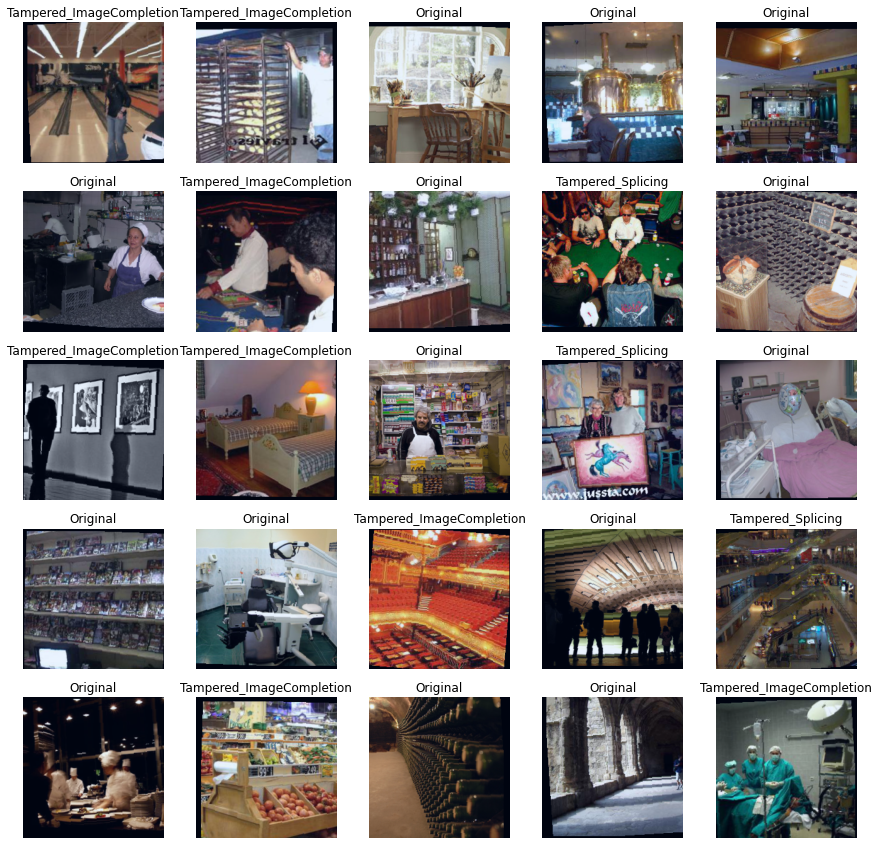

In [18]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [19]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [20]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [21]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [22]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [23]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [24]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [25]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [26]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

In [27]:
cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [3, 3, 3],
                                     channels = [16, 32, 64])

cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [5, 5, 5],
                                     channels = [16, 32, 64])

cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [7, 7, 7],
                                     channels = [16, 32, 64])

cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [9, 9, 9],
                                     channels = [16, 32, 64])

cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock,
                                      n_blocks = [18, 18, 18],
                                      channels = [16, 32, 64])

cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock,
                                       n_blocks = [20, 20, 20],
                                       channels = [16, 32, 64])

In [28]:
pretrained_model = models.resnet50(pretrained = True)

In [65]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [30]:
pretrained_model.fc = fc

In [31]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [32]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,514,179 trainable parameters


In [34]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [35]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [73]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [74]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

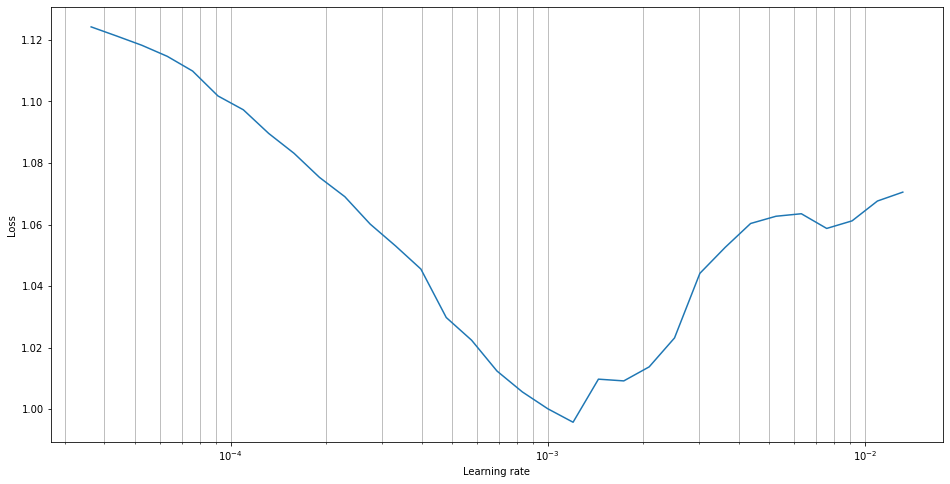

In [75]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [36]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [37]:
EPOCHS = 100
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [38]:
def calculate_topk_accuracy(y_pred, y, k = 1):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [39]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in tqdm(iterator):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [40]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
for param in pretrained_model.parameters():
    param.requires_grad = False
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

In [ ]:
torch.cuda.empty_cache()

best_valid_loss = float('inf')

for epoch in tqdm(range(EPOCHS)):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
    
    torch.save(model.state_dict(), '/scratch/dpj7913/CV/model.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 19m 5s
	Train Loss: 0.727 | Train Acc @1:  64.30% | Train Acc @5:  64.30%
	Valid Loss: 0.838 | Valid Acc @1:  58.76% | Valid Acc @5:  58.76%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 6m 11s
	Train Loss: 0.581 | Train Acc @1:  73.13% | Train Acc @5:  73.13%
	Valid Loss: 1.103 | Valid Acc @1:  51.40% | Valid Acc @5:  51.40%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 5m 54s
	Train Loss: 0.521 | Train Acc @1:  76.28% | Train Acc @5:  76.28%
	Valid Loss: 0.965 | Valid Acc @1:  56.08% | Valid Acc @5:  56.08%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 5m 54s
	Train Loss: 0.481 | Train Acc @1:  78.55% | Train Acc @5:  78.55%
	Valid Loss: 0.938 | Valid Acc @1:  59.61% | Valid Acc @5:  59.61%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 5m 54s
	Train Loss: 0.445 | Train Acc @1:  80.16% | Train Acc @5:  80.16%
	Valid Loss: 0.969 | Valid Acc @1:  58.39% | Valid Acc @5:  58.39%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 5m 53s
	Train Loss: 0.426 | Train Acc @1:  80.90% | Train Acc @5:  80.90%
	Valid Loss: 1.092 | Valid Acc @1:  54.91% | Valid Acc @5:  54.91%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 5m 53s
	Train Loss: 0.408 | Train Acc @1:  82.13% | Train Acc @5:  82.13%
	Valid Loss: 0.949 | Valid Acc @1:  61.78% | Valid Acc @5:  61.78%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 5m 53s
	Train Loss: 0.394 | Train Acc @1:  82.41% | Train Acc @5:  82.41%
	Valid Loss: 0.753 | Valid Acc @1:  67.44% | Valid Acc @5:  67.44%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 5m 53s
	Train Loss: 0.380 | Train Acc @1:  83.11% | Train Acc @5:  83.11%
	Valid Loss: 1.179 | Valid Acc @1:  56.73% | Valid Acc @5:  56.73%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 5m 53s
	Train Loss: 0.376 | Train Acc @1:  83.69% | Train Acc @5:  83.69%
	Valid Loss: 1.033 | Valid Acc @1:  59.54% | Valid Acc @5:  59.54%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 5m 53s
	Train Loss: 0.366 | Train Acc @1:  83.87% | Train Acc @5:  83.87%
	Valid Loss: 1.324 | Valid Acc @1:  52.32% | Valid Acc @5:  52.32%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 5m 53s
	Train Loss: 0.364 | Train Acc @1:  84.08% | Train Acc @5:  84.08%
	Valid Loss: 0.754 | Valid Acc @1:  67.81% | Valid Acc @5:  67.81%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 5m 53s
	Train Loss: 0.354 | Train Acc @1:  84.61% | Train Acc @5:  84.61%
	Valid Loss: 0.871 | Valid Acc @1:  61.73% | Valid Acc @5:  61.73%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 5m 53s
	Train Loss: 0.352 | Train Acc @1:  84.74% | Train Acc @5:  84.74%
	Valid Loss: 0.781 | Valid Acc @1:  65.36% | Valid Acc @5:  65.36%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 5m 53s
	Train Loss: 0.342 | Train Acc @1:  85.18% | Train Acc @5:  85.18%
	Valid Loss: 0.857 | Valid Acc @1:  66.17% | Valid Acc @5:  66.17%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 5m 53s
	Train Loss: 0.335 | Train Acc @1:  85.58% | Train Acc @5:  85.58%
	Valid Loss: 1.016 | Valid Acc @1:  60.42% | Valid Acc @5:  60.42%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 5m 53s
	Train Loss: 0.328 | Train Acc @1:  85.75% | Train Acc @5:  85.75%
	Valid Loss: 0.732 | Valid Acc @1:  71.49% | Valid Acc @5:  71.49%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 5m 53s
	Train Loss: 0.322 | Train Acc @1:  86.10% | Train Acc @5:  86.10%
	Valid Loss: 1.149 | Valid Acc @1:  58.71% | Valid Acc @5:  58.71%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 5m 53s
	Train Loss: 0.325 | Train Acc @1:  86.12% | Train Acc @5:  86.12%
	Valid Loss: 0.550 | Valid Acc @1:  77.06% | Valid Acc @5:  77.06%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 5m 54s
	Train Loss: 0.309 | Train Acc @1:  86.62% | Train Acc @5:  86.62%
	Valid Loss: 1.258 | Valid Acc @1:  58.29% | Valid Acc @5:  58.29%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 6m 11s
	Train Loss: 0.306 | Train Acc @1:  86.64% | Train Acc @5:  86.64%
	Valid Loss: 0.662 | Valid Acc @1:  72.14% | Valid Acc @5:  72.14%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 5m 54s
	Train Loss: 0.301 | Train Acc @1:  86.85% | Train Acc @5:  86.85%
	Valid Loss: 0.805 | Valid Acc @1:  69.97% | Valid Acc @5:  69.97%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 5m 58s
	Train Loss: 0.284 | Train Acc @1:  87.63% | Train Acc @5:  87.63%
	Valid Loss: 0.919 | Valid Acc @1:  66.73% | Valid Acc @5:  66.73%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 5m 54s
	Train Loss: 0.276 | Train Acc @1:  87.69% | Train Acc @5:  87.69%
	Valid Loss: 0.624 | Valid Acc @1:  74.39% | Valid Acc @5:  74.39%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 5m 53s
	Train Loss: 0.267 | Train Acc @1:  88.34% | Train Acc @5:  88.34%
	Valid Loss: 0.585 | Valid Acc @1:  77.23% | Valid Acc @5:  77.23%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 5m 54s
	Train Loss: 0.270 | Train Acc @1:  88.07% | Train Acc @5:  88.07%
	Valid Loss: 0.540 | Valid Acc @1:  77.54% | Valid Acc @5:  77.54%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 5m 54s
	Train Loss: 0.262 | Train Acc @1:  88.46% | Train Acc @5:  88.46%
	Valid Loss: 0.466 | Valid Acc @1:  80.19% | Valid Acc @5:  80.19%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 5m 59s
	Train Loss: 0.259 | Train Acc @1:  88.66% | Train Acc @5:  88.66%
	Valid Loss: 0.457 | Valid Acc @1:  79.59% | Valid Acc @5:  79.59%


  0%|          | 0/519 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 5m 54s
	Train Loss: 0.255 | Train Acc @1:  88.59% | Train Acc @5:  88.59%
	Valid Loss: 0.418 | Valid Acc @1:  82.14% | Valid Acc @5:  82.14%


  0%|          | 0/519 [00:00<?, ?it/s]